In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = "archive"
image_files = [file for file in os.listdir(path) if file.lower().endswith(('.png','.jpg'))]

def assign_label(filename):
    if filename.startswith('Human'):
        return 1  
    else:
        return 0  

data = []

for file in image_files:
    full_path = os.path.join(path, file)
    label = assign_label(file)
    data.append({'filename': full_path, 'label': label})

df = pd.DataFrame(data)
print(df['label'].value_counts()) 

label
0    3477
1    2543
Name: count, dtype: int64


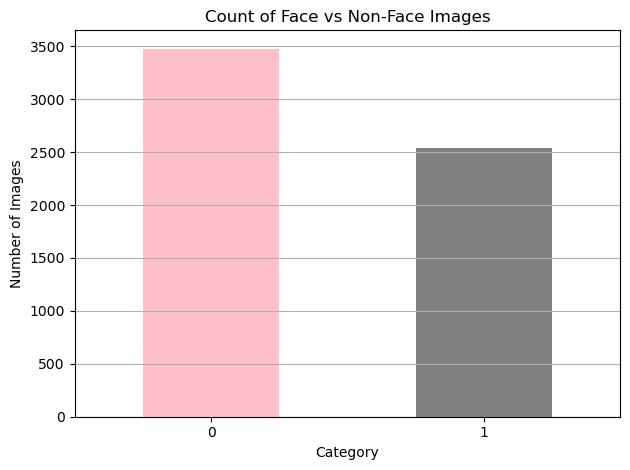

In [3]:
df['label'].value_counts().plot.bar(color=['pink', 'grey'])

plt.title("Count of Face vs Non-Face Images")
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


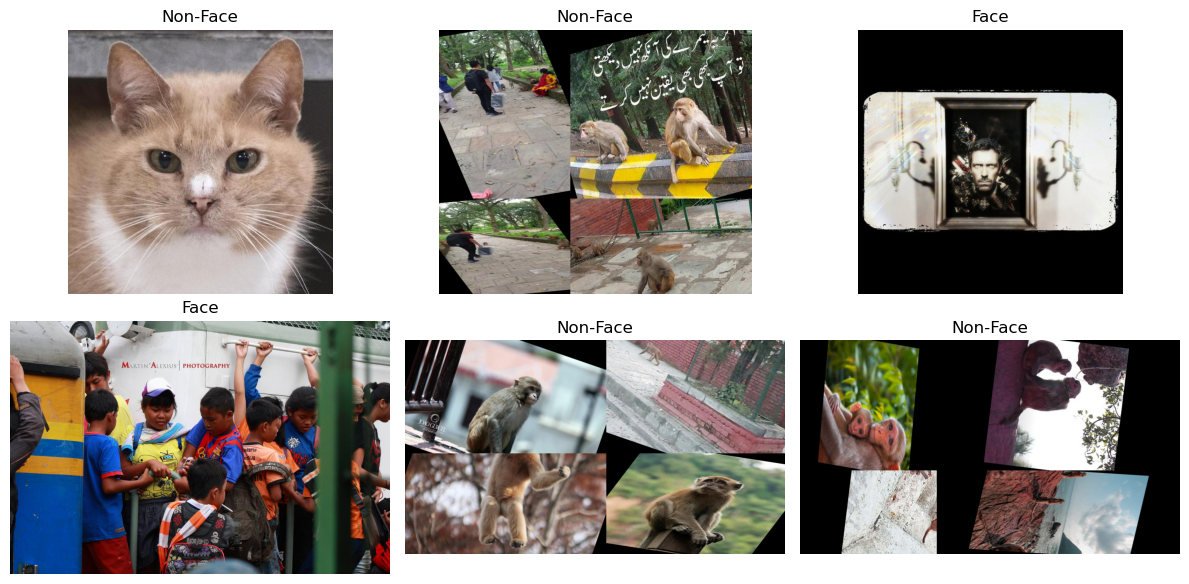

In [4]:
plt.figure(figsize=(12, 6))
for i in range(6):
    img = Image.open(df.iloc[i]['filename'])
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title("Face" if df.iloc[i]['label'] == 1 else "Non-Face")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
def preprocess_images(df, img_size=(224, 224)):
    images, labels = [], []
    for _, row in df.iterrows():
        img = load_img(row['filename'], target_size=img_size)
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
        labels.append(row['label'])
    return np.array(images), np.array(labels)

X, y = preprocess_images(df)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)


In [7]:
model = Sequential()

# Convolution layers
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.3))
model.add(Flatten())

# Dense layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))

# Output layer
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,validation_data=(X_val, y_val),epochs=10,batch_size=32,callbacks=[early_stop],verbose=1)

2025-07-08 12:36:54.632199: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10
151/151 [==============================] - 349s 2s/step - loss: 0.5650 - accuracy: 0.6763 - val_loss: 0.5602 - val_accuracy: 0.6628
Epoch 2/10
151/151 [==============================] - 353s 2s/step - loss: 0.5579 - accuracy: 0.6564 - val_loss: 0.5906 - val_accuracy: 0.6196
Epoch 3/10
151/151 [==============================] - 370s 2s/step - loss: 0.5497 - accuracy: 0.6557 - val_loss: 0.5436 - val_accuracy: 0.6553
Epoch 4/10
151/151 [==============================] - 385s 3s/step - loss: 0.5330 - accuracy: 0.6703 - val_loss: 0.5359 - val_accuracy: 0.6661
Epoch 5/10
151/151 [==============================] - 388s 3s/step - loss: 0.5209 - accuracy: 0.6752 - val_loss: 0.5297 - val_accuracy: 0.6603
Epoch 6/10
151/151 [==============================] - 376s 2s/step - loss: 0.5151 - accuracy: 0.6713 - val_loss: 0.5178 - val_accuracy: 0.6777
Epoch 7/10
151/151 [==============================] - 372s 2s/step - loss: 0.4852 - accuracy: 0.6952 - val_loss: 0.5432 - val_accuracy: 0.6661

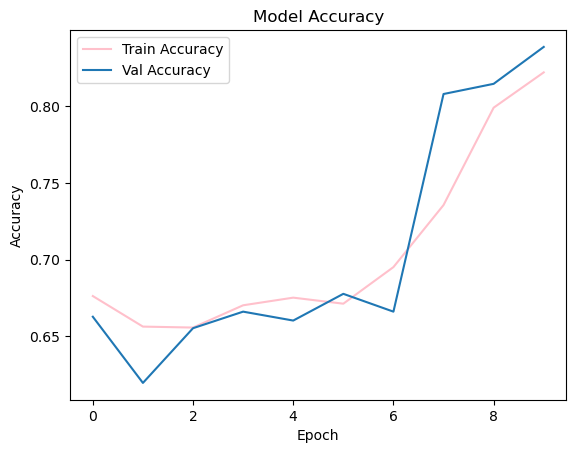

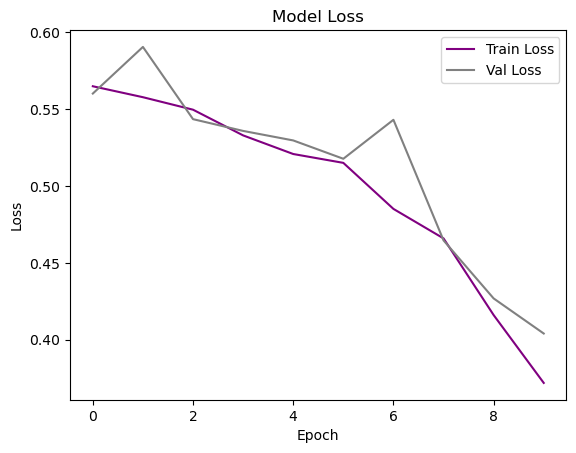

In [9]:
plt.plot(history.history['accuracy'], label='Train Accuracy',color='pink')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss',color='purple')
plt.plot(history.history['val_loss'], label='Val Loss',color='grey')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()
plt.show()


38/38 [==============================] - 26s 673ms/step
Accuracy Score: 0.8388704318936877
Classification Report:
              precision    recall  f1-score   support

    Non-Face       0.88      0.83      0.86       695
        Face       0.79      0.85      0.82       509

    accuracy                           0.84      1204
   macro avg       0.83      0.84      0.84      1204
weighted avg       0.84      0.84      0.84      1204



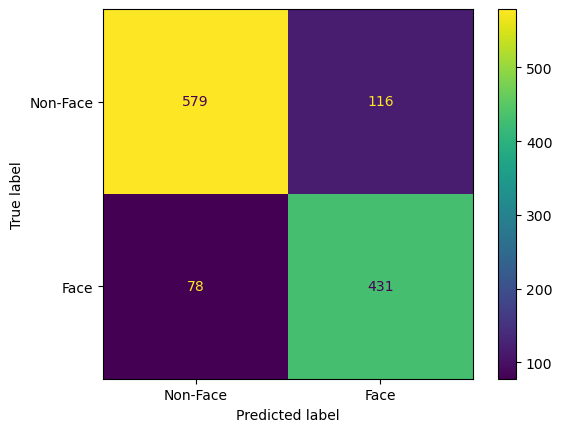

In [10]:
y_pred = (model.predict(X_val) > 0.5).astype("int32").flatten()

# Accuracy score
acc = accuracy_score(y_val, y_pred)
print("Accuracy Score:", acc)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=["Non-Face", "Face"]))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, display_labels=["Non-Face", "Face"])
plt.show()


In [11]:
model.save("face_nonface_model.h5")

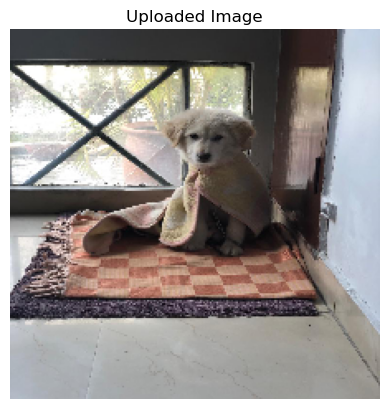

1/1 [==============================] - 0s 34ms/step
Prediction: Non-Face


In [23]:
img_path = "test1.png" 
img = load_img("test1.png", target_size=(224, 224))

plt.imshow(img)
plt.title("Uploaded Image")
plt.axis("off")
plt.show()


img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)[0][0]
label = "Face" if prediction > 0.5 else "Non-Face"

print("Prediction:", label)

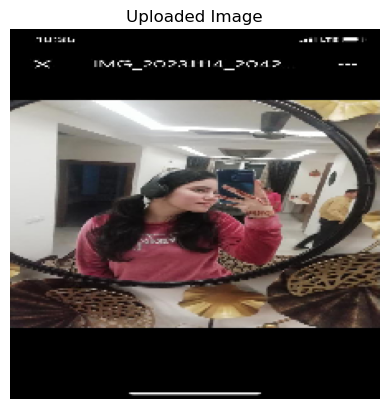

1/1 [==============================] - 0s 33ms/step
Prediction: Face


In [19]:
img_path = "test2.png" 
img = load_img("test2.png", target_size=(224, 224))

plt.imshow(img)
plt.title("Uploaded Image")
plt.axis("off")
plt.show()


img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)[0][0]
label = "Face" if prediction > 0.5 else "Non-Face"

print("Prediction:", label)

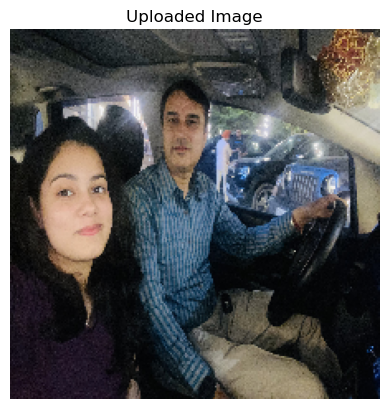

1/1 [==============================] - 0s 89ms/step
Prediction: Face


In [22]:
img_path = "test3.png" 
img = load_img("test3.png", target_size=(224, 224))

plt.imshow(img)
plt.title("Uploaded Image")
plt.axis("off")
plt.show()


img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)[0][0]
label = "Face" if prediction > 0.5 else "Non-Face"

print("Prediction:", label)